# LSTM model

## Notebook set-up

In [1]:
# Standard library imports
import os
import logging
from typing import Tuple

# PyPI imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, roc_curve, precision_recall_curve
from tensorflow import random
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Random
random_state=315

# Fix Tensorflow's global random seed
random.set_seed(random_state)

# Suppress warning and info messages from tensorflow
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Input data
data_file='../data/resampled_disaster_data_all.parquet'

2025-01-21 23:46:03.930670: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-21 23:46:04.414474: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-21 23:46:04.639065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737503165.045972    1745 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737503165.137898    1745 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-21 23:46:05.947013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

## 1. Data loading

In [2]:
data_df=pd.read_parquet(data_file)

total_disaster_months=len(data_df[data_df['incidents_binary'] != 0])
percent_disaster_months=(total_disaster_months/len(data_df)) * 100
print(f'Have {total_disaster_months}({percent_disaster_months:.1f}%) disaster months\n')

data_df.info()

Have 1986(4.7%) disaster months

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 41899 entries, (np.int64(1955), 'AK', np.int64(1)) to (np.int64(2019), 'WY', np.int64(12))
Data columns (total 62 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   incidents         41899 non-null  float64
 1   month_sin         41899 non-null  float64
 2   month_cos         41899 non-null  float64
 3   AL                41899 non-null  int64  
 4   AR                41899 non-null  int64  
 5   AS                41899 non-null  int64  
 6   AZ                41899 non-null  int64  
 7   CA                41899 non-null  int64  
 8   CO                41899 non-null  int64  
 9   CT                41899 non-null  int64  
 10  DC                41899 non-null  int64  
 11  DE                41899 non-null  int64  
 12  FL                41899 non-null  int64  
 13  FM                41899 non-null  int64  
 14  GA                41899 non-null  in

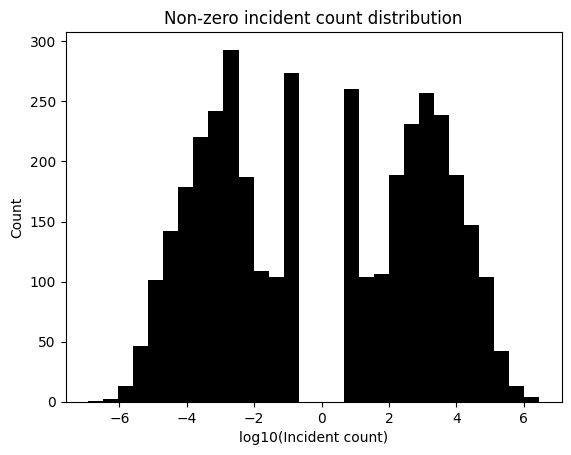

In [3]:
# Draw a quick plot to check the distribution of disaster counts
plt.title('Non-zero incident count distribution')
plt.hist(data_df['incidents'][data_df['incidents'] != 0], bins=30, color='black')
plt.xlabel('log10(Incident count)')
plt.ylabel('Count')
plt.show()

## 2. Data batching function

In [4]:
def generate_data(data_df: pd.DataFrame, input_window: int) -> Tuple[np.array, np.array]:
    '''Takes dataframe, input window size, parses data into feature label pairs,
    where features are a contiguous sequence of months and label is binarized
    incidents from the next month, returns as tuple of numpy arrays'''

    # Get list of states
    states=data_df.index.get_level_values('state').unique().tolist()

    features=[]
    labels=[]

    # Loop on states
    for state in states:

        # Extract the data for this state
        state_df=data_df.loc[:,state,:]

        # Indexing variable for batch
        input_start_index=0

        # Loop on the state data
        while input_start_index + input_window + 1 < len(state_df):

            # Extract and collect the features
            feature_row=state_df.iloc[input_start_index:input_start_index + input_window, :-1]
            features.append(feature_row.values.tolist())

            # Extract and collect the labels
            labels.append(state_df.iloc[input_start_index + input_window, -1])

            # Update the index
            input_start_index+=1

    return np.array(features), np.array(labels)

## 3. Train-test split

In [5]:
# Generate feature, label pairs
input_window=6
features, labels=generate_data(data_df, input_window)

In [6]:
# Split features and labels into training and validation
training_features, testing_features, training_labels, testing_labels=train_test_split(
    features,
    labels,
    random_state=random_state
)

Training features: (31119, 6, 61)
Training labels: (31119,), 4.8% positive class
Testing features: (10373, 6, 61)
Testing labels: (10373,), 4.5% positive class

Sample training features: [0.        0.8660254 0.5       0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        1.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.       ]
Sample training label: 0


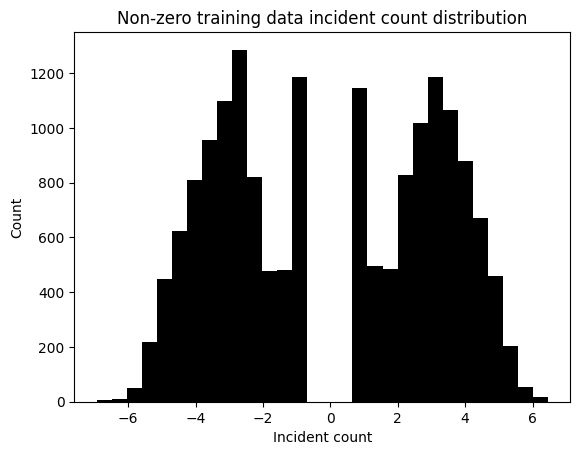

In [7]:
# Sanity check data shape and distribution
print(f'Training features: {training_features.shape}')
print(f'Training labels: {training_labels.shape}, {(sum(training_labels)/len(training_labels))*100:.1f}% positive class')
print(f'Testing features: {testing_features.shape}')
print(f'Testing labels: {testing_labels.shape}, {(sum(testing_labels)/len(testing_labels))*100:.1f}% positive class\n')
print(f'Sample training features: {training_features[0,0]}')
print(f'Sample training label: {training_labels[0]}')

# Draw a quick plot to check the distribution of disaster counts
training_disaster_counts=training_features[:,:,0].flatten()
nonzero_training_disaster_counts=training_disaster_counts[np.nonzero(training_disaster_counts)]

plt.title('Non-zero training data incident count distribution')
plt.hist(nonzero_training_disaster_counts, bins=30, color='black')
plt.xlabel('Incident count')
plt.ylabel('Count')
plt.show()

## 4. Model training

### 4.1. Model definition function

In [8]:
# Helper function to build model
def build_lstm(training_features: np.array, learning_rate: float=0.0001) -> keras.models.Sequential:
    '''Builds and compiles LSTM model'''

    # Define and adapt a normalization layer.
    norm_layer=keras.layers.Normalization()
    norm_layer.adapt(training_features)

    # Set-up the L1L2 for the dense layers
    regularizer=keras.regularizers.L1L2(l1=0.002, l2=0.02) # Last best state: 0.001, 0.01

    # Define the model
    model=Sequential()
    model.add(layers.Input((training_features.shape[1],training_features.shape[2])))
    model.add(norm_layer) # Norm layer off
    model.add(layers.LSTM(512)) # Last best state: 512
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizer))
    model.add(layers.Dense(32, activation='relu', kernel_regularizer=regularizer))
    model.add(layers.Dense(1, activation='sigmoid'))

    # Define the optimizer
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate)

    # Compile the model, specifying the type of loss to use during training and any extra metrics to evaluate
    model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=optimizer, metrics=[keras.metrics.Recall(), keras.metrics.Precision()])

    return model

### 4.2. Training function

In [9]:
# Helper function to train model
def train_lstm(
        model: keras.models.Sequential,
        training_features: np.array,
        training_labels: np.array,
        testing_features: np.array,
        testing_labels: np.array,
        epochs: int=10,
        batch_size: int=64
):
    
    '''Does one LSTM training run'''

    # Class weighting scheme suggested in: https://keras.io/examples/structured_data/imbalanced_classification/
    # Class weighting scheme suggested in: https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights
    pos_examples=training_labels.sum()
    neg_examples=len(training_labels) - pos_examples
    neg_class_weight=(1 / neg_examples) * (len(training_labels) / 2.0)
    pos_class_weight=(1 / pos_examples) * (len(training_labels) / 2.0)
    class_weight={0: neg_class_weight, 1: pos_class_weight}

    print(f'Class weights: {class_weight}')

    # Train the model
    result=model.fit(
        training_features,
        training_labels,
        validation_data=(testing_features, testing_labels),
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        class_weight=class_weight
    )

    return result, model

### 4.3. Training curve ploting function

In [10]:
# Define a re-useable helper function that plots the results of a single training run
def plot_single_training_run(training_results):
    '''Takes a training results dictionary, plots it.'''

    # Set-up a 1x3 figure for metrics
    fig, axs=plt.subplots(1,3, figsize=(9,3))

    # Add the main title
    fig.suptitle('LSTM training curves', size='large')

    # Plot training and validation recall
    axs[0].set_title('Binary cross-entropy')
    axs[0].plot(training_results.history['loss'], label='Training')
    axs[0].plot(training_results.history['val_loss'], label='Validation')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Binary cross-entropy')
    axs[0].legend(loc='upper right')

    # Plot training and validation precision
    axs[1].set_title('Precision')
    axs[1].plot(training_results.history['precision'])
    axs[1].plot(training_results.history['val_precision'])
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Precision score')

    axs[2].set_title('Recall')
    axs[2].plot(training_results.history['recall'], label='Training')
    axs[2].plot(training_results.history['val_recall'], label='Validation')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Recall score')

    # Show the plot
    plt.tight_layout()

    return plt

### 4.4. Baseline LSTM training run

In [ ]:
%%time

model=build_lstm(training_features, learning_rate=0.000005)
model.summary()

result, model=train_lstm(
    model,
    training_features,
    training_labels,
    testing_features,
    testing_labels,
    epochs=500,
    batch_size=256
)

plot_single_training_run(result).show()

2025-01-21 23:47:10.831730: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 6, 61)          │           123 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 512)            │     1,175,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,245,500 (4.75 MB)

 Trainable params: 1,245,377 (4.75 MB)

 Non-trainable params: 123 (496.00 B)

Class weights: {0: np.float64(0.5252506498329002), 1: np.float64(10.400735294117647)}
Epoch 1/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 31s 240ms/step - loss: 12.9060 - precision: 0.0490 - recall: 0.9133 - val_loss: 12.8473 - val_precision: 0.0438 - val_recall: 0.8996
Epoch 2/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 37s 210ms/step - loss: 12.7417 - precision: 0.0490 - recall: 0.9051 - val_loss: 12.6773 - val_precision: 0.0445 - val_recall: 0.9060
Epoch 3/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 209ms/step - loss: 12.5788 - precision: 0.0493 - recall: 0.9007 - val_loss: 12.5101 - val_precision: 0.0450 - val_recall: 0.9103
Epoch 4/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 26s 209ms/step - loss: 12.4167 - precision: 0.0498 - recall: 0.9020 - val_loss: 12.3454 - val_precision: 0.0473 - val_recall: 0.8868
Epoch 5/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 41s 211ms/step - loss: 12.2583 - precision: 0.0497 - recall: 0.8823 - val_loss: 12.1832 - val_precision: 0.0504 - val_recall: 0.8761
Epoch 6/500
122/122 ━━━━━━━━━━━━━━━━━━━━ 42s

## 5. Model evaluation

### 5.1. Make predictions on test set

In [12]:
predictions=model.predict(testing_features)
predictions_df=pd.DataFrame.from_dict({'labels': testing_labels.flatten(), 'probabilities': predictions.flatten()})
predictions_df.head()

325/325 [==============================] - 1s 3ms/step


,labels,probabilities
0,0,0.701821
1,0,0.572527
2,0,0.339008
3,0,0.506918
4,0,0.562311


### 5.2. Distribution of predicted incident probabilities

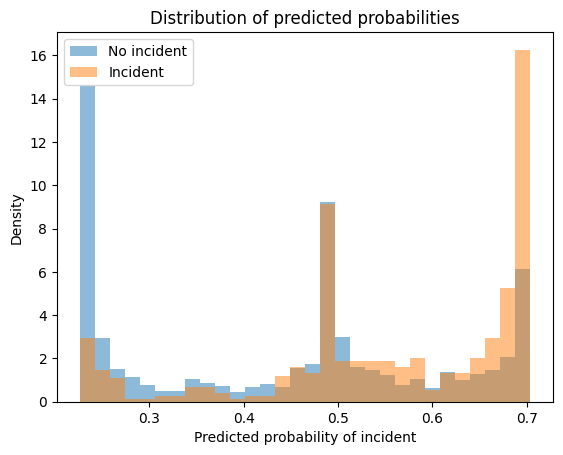

In [13]:
plt.title('Distribution of predicted probabilities')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 0], bins=30, density=True, alpha=0.5, label='No incident')
plt.hist(predictions_df['probabilities'][predictions_df['labels'] == 1], bins=30, density=True, alpha=0.5, label='Incident')
plt.xlabel('Predicted probability of incident')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

### 5.3. Receiver-operator characteristic and precision-recall curves

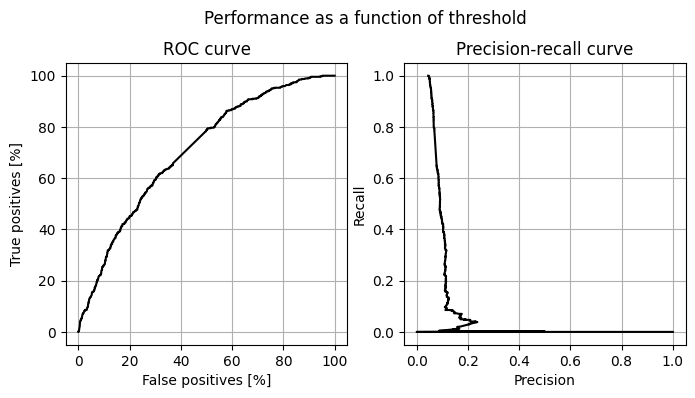

In [14]:
# Set-up a 1x2 figure
fig, axs=plt.subplots(1,2, figsize=(8,4))

# Add the main title
fig.suptitle('Performance as a function of threshold', size='large')

# Plot ROC curve
fp, tp, _ = roc_curve(testing_labels, predictions)
axs[0].set_title('ROC curve')
axs[0].plot(100*fp, 100*tp, color='black')
axs[0].set_xlabel('False positives [%]')
axs[0].set_ylabel('True positives [%]')
axs[0].grid(True)
axs[0].set_aspect('equal')

# Plot PR curve
precision, recall, _ = precision_recall_curve(testing_labels, predictions)
axs[1].set_title('Precision-recall curve')
axs[1].plot(precision, recall, color='black')
axs[1].set_xlabel('Precision')
axs[1].set_ylabel('Recall')
axs[1].grid(True)
axs[1].set_aspect('equal')

### 5.4. Confusion matrix

Precision: 0.079
Recall: 0.643



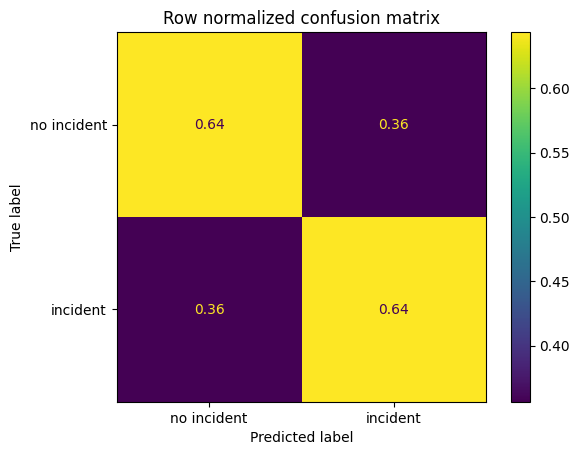

In [15]:
# Set threshold and call incidents
threshold=0.5
calls=np.where(predictions > threshold, 1, 0)

# Calculate precision and recall
precision=precision_score(testing_labels, calls)
recall=recall_score(testing_labels, calls)
print(f'Precision: {precision:.3f}')
print(f'Recall: {recall:.3f}\n')

# Plot the confusion matrix
cm=confusion_matrix(testing_labels, calls, normalize='true')
cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['no incident', 'incident'])
_=cm_disp.plot()
plt.title('Row normalized confusion matrix')
plt.show()